First let's import required modules:

In [1]:
import skvideo.io
import skimage.io
from skimage import color,exposure
import skvideo.datasets
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

This function is to give an error if a video specified by the reader object don't have an $n^{th}$ frame.

In [2]:
def frameCountError(reader,n):
    # get total number of frames in the video
    T = reader.getShape()[0]
    # give error if n>T
    if n>T:
        reader.close()
        raise ValueError("n should be less than or equal to %i, the total number frames in the video"%T)

This is to get the $n^{th}$ frame.

In [3]:
def getFrame(video,n):
    """
        returns the n th frame of the video
        this is slow.
        Only use for debugging
    """
    reader = skvideo.io.FFmpegReader(video)
    frameCountError(reader,n)
    counter = 1
    for frame in reader.nextFrame():
        if counter == n:
            reader.close()
            return frame
        counter+=1

# Investigation on the difference in pixel values

This section looks at how many portion pixels is increased/decreased and not changed between two adjacent frames.

load video

In [4]:
video = skvideo.datasets.bigbuckbunny()

get 1st frame

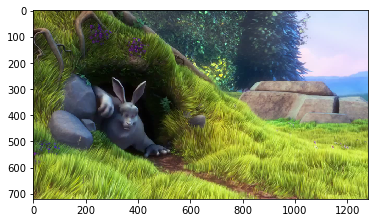

In [7]:
frame1 = getFrame(video,1)
plt.imshow(frame1)
plt.show()

get second frame

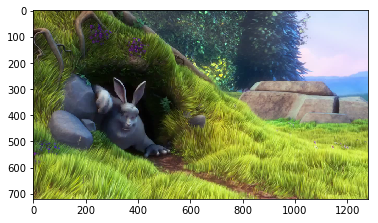

In [8]:
frame2 = getFrame(video,2)
plt.imshow(frame2)
plt.show()

define a function that gives increased and stayed same pixels

In [5]:
def getDif(lastframe,frame,plane):
    """
        this gives 2 outputs regarding the specified plane of lastframe and frame

        dif: 
        eq:
    """
    dif = (lastframe[:,:,plane]>frame[:,:,plane])
    eq =  (lastframe[:,:,plane]==frame[:,:,plane])
    return dif,eq

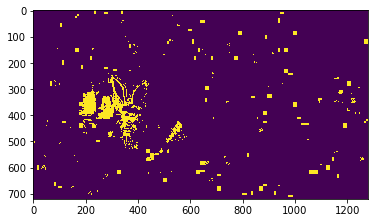

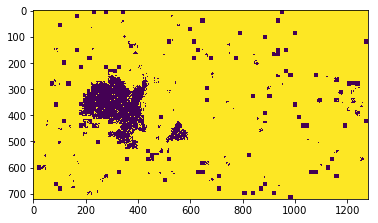

In [10]:
dif1,eq1 = getDif(frame1,frame2,0)
np.save()
plt.imshow(dif1);plt.show()
plt.imshow(eq1);plt.show()

Since this video is very slow, 2 consecutive frames have very much similarities. Yellow means 1 and purple means 0. Let's observe the percentages of pixel values that were,
1. increased
2. decreased
3. stayed the same

> **Comment:** _Video sould not be necessarilly slow to have results like above. Later...._

In [11]:
dif1.shape

(720, 1280)

In [12]:
totalPixels = 720*1280

In [13]:
increased_percentage = np.sum(dif1)/totalPixels
equal_percentage = np.sum(eq1)/totalPixels
decreased_percentage = 1-(increased_percentage+equal_percentage)
print(
    "increased_percentage = %.4f\n"%increased_percentage,
    "decreased_percentage = %.4f\n"%decreased_percentage,
    "equal_percentage = %.4f\n"%equal_percentage
)

increased_percentage = 0.0399
 decreased_percentage = 0.0388
 equal_percentage = 0.9213



Lets define a function to give us above parameters once given dif and eq, for future use.

In [6]:
def giveCounts(dif,eq):
    """
        This will return decreased and increased pixel counts
        respectively
    """
    increased_count = np.sum(dif)
    equal_count = np.sum(eq)
    decreased_count = dif.size-increased_count-equal_count
    return np.array([increased_count, decreased_count])

Let's check that function.

In [15]:
giveCounts(dif1,eq1)/totalPixels

array([ 0.03994249,  0.03878798])

Lets check how these 2 values, increased count and decreased count change. from frame to frame.

get all giveCounts for our video

define a function that outputs increased count, decreased count for first n frames of given video

In [7]:
def getDifData(video,n):
    
    lastFrame = getFrame(video,1)
    
    count = 0
    increased_count_list = np.array([0]*n)
    decreased_count_list = np.array([0]*n)
    frame_list = np.array([0]*n)
    
    reader = skvideo.io.FFmpegReader(video)
    frameCountError(reader,n)
    
    for frame in reader.nextFrame():
        if count == 0:
            count += 1
        elif count<n+1:
            dif,eq = getDif(lastFrame,frame,0)            
            lastFrame = frame
            increased_count_list[count-1], decreased_count_list[count-1] = giveCounts(dif,eq)
            frame_list[count-1]=count
            count+=1
        else:
            break
    reader.close()
    return np.array([increased_count_list,decreased_count_list,frame_list])    

Check if it works fine

In [17]:
data = (getDifData(video,10))
data

array([[ 36811,  37410,  45375,  75741, 146234, 188125,   8845, 189393,
        240724, 249854],
       [ 35747,  37865,  57065, 101948, 187131, 213759,   9699, 220389,
        274319, 282467],
       [     1,      2,      3,      4,      5,      6,      7,      8,
             9,     10]])

That's ok. but for the first 10 frame differences, the increased_count is **always** less than decreased_count. Let's plot those values for 1st 130 frames of the video.

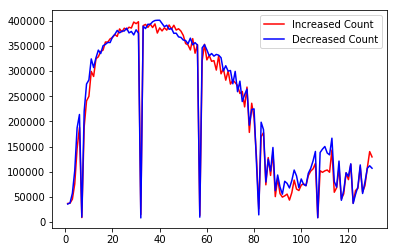

In [18]:
data = getDifData(video,130)
plot1, = plt.plot(data[2],data[0],'r', label = 'Increased Count')
plot2, = plt.plot(data[2],data[1],'b', label = 'Decreased Count')
plt.legend(handles = [plot1,plot2])
plt.show()

Sometimes there may be identical frames one after other. That's why there are zeros here and there.

Let's define a function to do what's done above $\uparrow$

In [8]:
def plotData(video,frames):
    data = getDifData(video,130)
    plot1, = plt.plot(data[2],data[0],'r', label = 'Increased Count')
    plot2, = plt.plot(data[2],data[1],'b', label = 'Decreased Count')
    plt.legend(handles = [plot1,plot2])
    plt.title("Behaviour for %s"%video)
    plt.show()

We can figure out the percentage of decreased count being greater than increased count

In [20]:
#instances of decreased>increased 
x = np.sum(data[1]>data[0])
#total instances
t = data[0].size
#percentage
p = x/t*100
p

64.615384615384613

For this video number of decreased pixel value transitions are greater than that of increased ones. IOW the probability of next frame being darker is higher. (with respect to plane 0 which is red plane.)

Let's do the same for other planes.
for that redefine our functions getDifData and plotData

In [9]:
def getDifData(video,n,plane):
    """
        gives difference data
        
    """
    
    lastFrame = getFrame(video,1)
    
    count = 0
    increased_count_list = np.array([0]*n)
    decreased_count_list = np.array([0]*n)
    frame_list = np.array([0]*n)
    
    reader = skvideo.io.FFmpegReader(video)
    frameCountError(reader,n)
    
    for frame in reader.nextFrame():
        if count == 0:
            count += 1
        elif count<n+1:
            dif,eq = getDif(lastFrame,frame,plane)            
            lastFrame = frame
            increased_count_list[count-1], decreased_count_list[count-1] = giveCounts(dif,eq)
            frame_list[count-1]=count
            count+=1
        else:
            break
    reader.close()
    return np.array([increased_count_list,decreased_count_list,frame_list])    

In [10]:
def plotData(video,frames,plane):
    data = getDifData(video,130,plane)
    plot1, = plt.plot(data[2],data[0],'r', label = 'Increased Count')
    plot2, = plt.plot(data[2],data[1],'b', label = 'Decreased Count')
    plt.legend(handles = [plot1,plot2])
    plt.title("Behaviour for %s"%video)
    plt.show()

In [23]:
data = getDifData(video,130,1)
#instances of decreased>increased 
x = np.sum(data[1]>data[0])
#total instances
t = data[0].size
#percentage
p = x/t*100
p

70.0

In [24]:
data = getDifData(video,130,2)
#instances of decreased>increased 
x = np.sum(data[1]>data[0])
#total instances
t = data[0].size
#percentage
p = x/t*100
p

86.15384615384616

We can say that overall the video is getting darker since p value is higher for all 3 planes.If we have a closer look at the video what happens is coming out of bibuckbunny's shadow. 

The feature: whether the overall intensity is increased or decreased is not a good one.

Let's check this for some other videos.
For our sample ads.

Let's define these plots as **in-dec** plots.

In [11]:
adPath = "D:/Ads/seperate trims/"
ads = [adPath+"ADD_%i.mp4"%i for i in range(1,9,1)]

In [9]:
getFrame(ads[0],1).shape

(576, 720, 3)

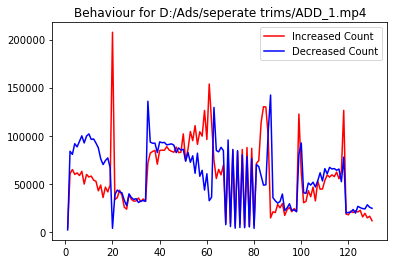

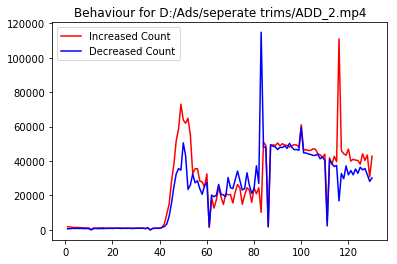

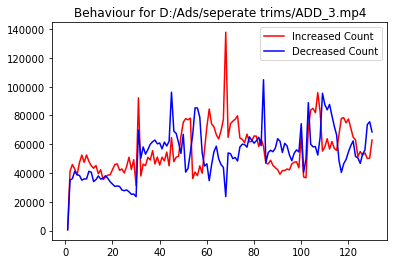

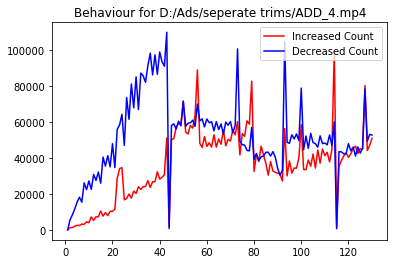

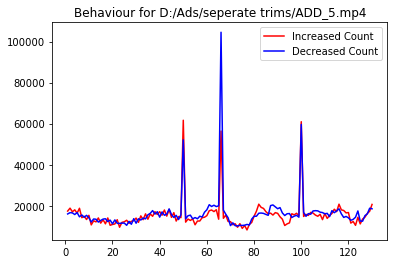

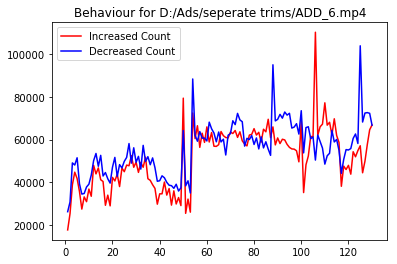

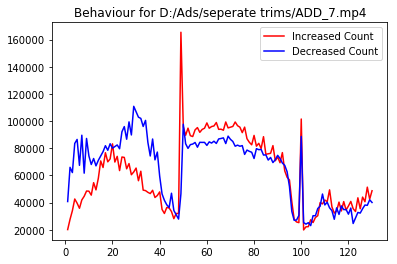

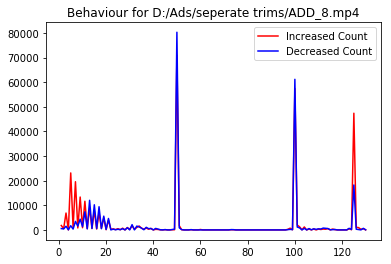

In [26]:
for ad in ads:
    plotData(ad,130,0)

Now let's calculate p statistic for the ads.

Define function calp to get that.

In [12]:
def calp(video,n,plane):
    
    data = getDifData(video,n,plane)
    #instances of decreased>increased 
    x = np.sum(data[1]>data[0])
    #total instances
    t = data[0].size
    #percentage
    p = x/t*100
    return p

In [13]:
def calpArray(videoArray,n,plane):
    """This gives p values for given videoArray
        n: consider only 1st n frames
        plane: for the given plane R, G or B
    """
    pVals = np.array([0]*8,dtype=np.float32)
    index = 0
    for video in videoArray:
        pVal = calp(video,130,0)
        pVals[index] = pVal
        index +=1
        print("%s : %.4f"%(video,pVal))    
    return pVals

In [29]:
ad_pVals = calpArray(ads,130,0)

D:/Ads/seperate trims/ADD_1.mp4 : 67.6923
D:/Ads/seperate trims/ADD_2.mp4 : 27.6923
D:/Ads/seperate trims/ADD_3.mp4 : 46.1538
D:/Ads/seperate trims/ADD_4.mp4 : 83.0769
D:/Ads/seperate trims/ADD_5.mp4 : 60.7692
D:/Ads/seperate trims/ADD_6.mp4 : 73.0769
D:/Ads/seperate trims/ADD_7.mp4 : 48.4615
D:/Ads/seperate trims/ADD_8.mp4 : 35.3846


In [30]:
ad_pVals

array([ 67.69230652,  27.69230843,  46.15384674,  83.07691956,
        60.76922989,  73.07691956,  48.46154022,  35.38461685], dtype=float32)

## Immunity to gamma correction.

Let's gamma correct the videos and check what happens to p.

first let's define a function to create a gamma adjusted version of a given video.

$$O=\frac{I_{max}I^{\gamma}}{I_{max}^{\gamma}}$$
Here  $I$ is the input frame $O$ is the output frame 

For `uint8` type frames $I_{max}=255$.

In [14]:
def gammaCorrect(inputvideo,outputvideo,gamma,n):
    reader = skvideo.io.FFmpegReader(inputvideo)
    writer = skvideo.io.FFmpegWriter(outputvideo)
    frameCountError(reader,n)
    counter = 0
    for frame in reader.nextFrame():
        outputFrame = np.uint8(255/(255**gamma)*np.float32(frame)**gamma)
        writer.writeFrame(outputFrame)
        counter += 1
        if counter == n: 
            break
    reader.close()
    writer.close()

In [15]:
g_ads = ["g_ad_%i.mp4"%i for i in range(1,9,1)]

In [33]:
GAMMA = .5
def gammaCorrectArray(inputvideoArray,outputvideoArray,gamma,n):
    for inputvideo,outputvideo in zip(inputvideoArray,outputvideoArray):
        gammaCorrect(inputvideo,outputvideo,GAMMA,n)
gammaCorrectArray(ads,g_ads,GAMMA,130)
g_ad_pVals = calpArray(g_ads,130,0)

g_ad_1.mp4 : 60.7692
g_ad_2.mp4 : 34.6154
g_ad_3.mp4 : 44.6154
g_ad_4.mp4 : 72.3077
g_ad_5.mp4 : 52.3077
g_ad_6.mp4 : 56.9231
g_ad_7.mp4 : 57.6923
g_ad_8.mp4 : 43.8462


The percentage difference due to gamma correction is,

In [34]:
difPercentage = (g_ad_pVals-ad_pVals)/ad_pVals*100
difPercentage

array([-10.22727299,  24.99999046,  -3.33333755, -12.96295834,
       -13.92404747, -22.10526085,  19.04761124,  23.91303635], dtype=float32)

The values have chaged as follows:

Original p | $\gamma$ corrected p
----------- | -----------------
67.6923 |60.7692
27.6923|34.6154
46.1538|44.6154
83.0769|72.3077
60.7692|52.3077
73.0769|56.9231
48.4615|57.6923
35.3846|43.8462

Due to the gamma correction, p stastic is changed within $\pm25\%$ margin. 

Define a function to **show** $n^{th}$ frame of a video.

In [16]:
def showFrame(video,n):
    plt.imshow(getFrame(video,n))
    plt.show()

> If we examine the **in-dec** plot of ad_1, we can see a saw tooth like behaviour around frame 70. Let's see what happens there.

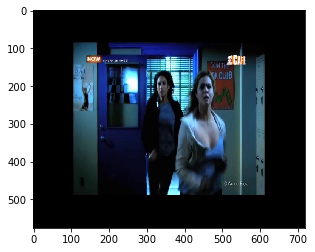

In [36]:
showFrame(ads[0],70)

Since our goal is being able to identify the video using 25 frames, **in-dec** parameter itself might be useful as a feature. 

[plan raw](plan.jpg)

First we'll suppose no offset/displacement of pixels and carry out identifying.

# Algorithm

## Rationale
![](rationale_of_algo.svg)


Assumptions:
1. fgfg

This is a basic algo without much consideration about optimisations.

![](Algo.svg)
For now $$\tt\text{matchScore}=\frac{\text{incSum}}{\text{sumInterest}}$$

# Implementation

The function 1 can be implemented as follows by slightly changing `getDif` function:

In [17]:
def getChange(lastframe,frame,plane):
    """
        this gives 3 outputs regarding the specified plane of lastframe and frame
        inc: 
        dec:
        incdec:
    """
    inc = (lastframe[:,:,plane]>frame[:,:,plane])
    dec =  (lastframe[:,:,plane]<frame[:,:,plane])
    incdec = np.logical_or(inc, dec)
    
    return np.array([inc,dec,incdec])

> Note that `incdec` is also calculated inside `getChange`

In [18]:
def getMatchScore(vid1,vid2):
    framesVid1 = [getFrame(vid1,1),getFrame(vid1,2)]
    framesVid2 = [getFrame(vid2,1),getFrame(vid2,2)]
    inc1,dec1,incdec1 = getChange(framesVid1[1],framesVid1[0],1)
    inc2,dec2,incdec2 = getChange(framesVid2[1],framesVid2[0],1)
    interestPoints = np.logical_and(incdec1,incdec2)
    cleanInc1,cleanInc2 = np.logical_and(interestPoints,np.array([inc1,inc2])) 
    incScoreMat = np.logical_xor(cleanInc1,cleanInc2)
    incScore = np.sum(incScoreMat)
    sumInterest = np.sum(interestPoints)
    if sumInterest:
        return (incScore)/sumInterest

Define a function to check the performance of the scoring function.

In [19]:
def getName(variable):
    for k,v in list(globals().items()):
        if v is variable:
            return k

In [20]:
def getMatchness(matchFunc,list1,list2):
    """This function says how good the matchFunc is."""
    l = []
    for i in range(8):
        m = []
        for j in range(8):
            score = matchFunc(list1[j],list2[i])
            m.append(score)
        l.append(m)
    plt.imshow(l, cmap='hot', interpolation='nearest')
    
    plt.xlabel("%s"%getName(list1))
    plt.ylabel("%s"%getName(list2))
    plt.show()

Scoring function performs well if the diagonal cells of the output from `getMatchness` is clearly distinguishable from the rest.

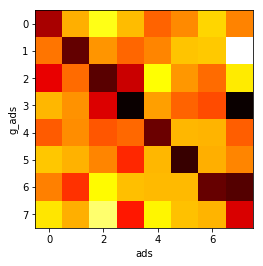

In [41]:
getMatchness(getMatchScore,ads,g_ads)

> **Note:** Here, `ads` represents the database we have and `g_ads` represents the same `ads` but deformed. (Specifically, `g_ads` are Gamma-Corrected versions of `ads`) In simple terms `g_ads` represents what's played on the tv, for which we have to identify the matches from `ads`. 
> 
> For example if `g_ads[0]` is played on the tv, it's compared with all the `ads` and the highest score is `ads[0]` which will be the match. This is a hit. But for `g_ads[6]`, it's not the case.
 
`getMatchScore` is not good. It's given that ads[7] and g_ads[3] are matching pairs falsely.

Since `getMatchScore` gives its score using only 2 frames, it's ability to differentiate is quite low. 

Let's extend it to match desired number of frames to get more accurate value.

In [21]:
def getMatchScoreExtended(vid1,vid2,n):
    """give score using first 3 frames using same algo
        as getMatchScore.
    """
    reader1 = skvideo.io.FFmpegReader(vid1)
    reader2 = skvideo.io.FFmpegReader(vid2)
    frameCountError(reader1,n+1)
    frameCountError(reader2,n+1)
    lastFrameVid1, lastFrameVid2 = reader1._readFrame(),reader2._readFrame()
    out = 0
    for i in range(n):
        nowFrameVid1,nowFrameVid2 = reader1._readFrame(),reader2._readFrame()
        inc1,dec1,incdec1 = getChange(lastFrameVid1,nowFrameVid1,1)
        inc2,dec2,incdec2 = getChange(lastFrameVid2,nowFrameVid2,1)
        lastFrameVid1,LastFrameVid2 = nowFrameVid1,nowFrameVid2
        interestPoints = np.logical_and(incdec1,incdec2)
        cleanInc1,cleanInc2 = np.logical_and(interestPoints,np.array([inc1,inc2])) 
        incScoreMat = np.logical_xor(cleanInc1,cleanInc2)
        incScore = np.sum(incScoreMat)
        sumInterest = np.sum(interestPoints)
        if sumInterest:
            out += (incScore)/sumInterest
    reader1.close()
    reader2.close()
    return out    

Now we have to extend the `getMatchnes` also.

In [22]:
def getMatchness(matchFunc,list1,list2,n):
    """This function says how good the matchFunc is."""
    l = []
    for i in range(8):
        m = []
        for j in range(8):
            score = matchFunc(list1[j],list2[i],n)
            m.append(score)
        l.append(m)
        
    plt.imshow(l, cmap='hot', interpolation='nearest')
    plt.xlabel("%s"%getName(list1))
    plt.ylabel("%s"%getName(list2))
    plt.show()

Let's get score using 3 frames.

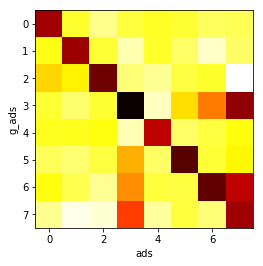

In [44]:
getMatchness(getMatchScoreExtended,ads,g_ads,3)

If we just ignore the mismatch ads[7] and g_ads[6], the performance is **dramatically** increased.

Let's go for 4 frames.'

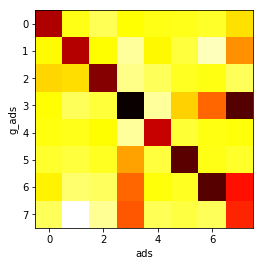

In [45]:
getMatchness(getMatchScoreExtended,ads,g_ads,4)

Not quite according to out expectations. 4th frame has devastated the match ads[7] and g_ads[7].

Any way try 5 frames!!

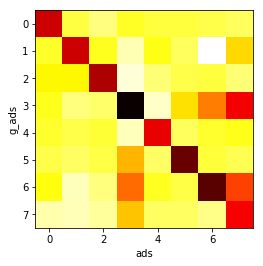

In [46]:
getMatchness(getMatchScoreExtended,ads,g_ads,5)

![](idea.png)

> !dea non maximum suppression or sth?

Let's slightly change our scoring function to be multiplicative not additive.'

In [23]:
def getMatchScoreExtendedMultiplicative(vid1,vid2,n):
    """give score using first n frames using same algo
        as getMatchScore.
    """
    reader1 = skvideo.io.FFmpegReader(vid1)
    reader2 = skvideo.io.FFmpegReader(vid2)
    frameCountError(reader1,n+1)
    frameCountError(reader2,n+1)
    lastFrameVid1, lastFrameVid2 = reader1._readFrame(),reader2._readFrame()
    out = 1
    for i in range(n):
        nowFrameVid1,nowFrameVid2 = reader1._readFrame(),reader2._readFrame()
        inc1,dec1,incdec1 = getChange(lastFrameVid1,nowFrameVid1,1)
        inc2,dec2,incdec2 = getChange(lastFrameVid2,nowFrameVid2,1)
        lastFrameVid1,LastFrameVid2 = nowFrameVid1,nowFrameVid2
        interestPoints = np.logical_and(incdec1,incdec2)
        cleanInc1,cleanInc2 = np.logical_and(interestPoints,np.array([inc1,inc2])) 
        incScoreMat = np.logical_xor(cleanInc1,cleanInc2)
        incScore = np.sum(incScoreMat)
        sumInterest = np.sum(interestPoints)
        if sumInterest:
            out *= (incScore)/sumInterest
    reader1.close()
    reader2.close()
    return out 

Do the thing for n=2,3,4 and 5

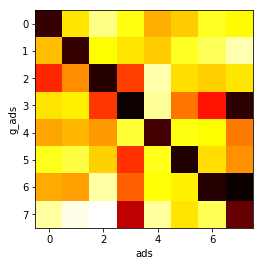

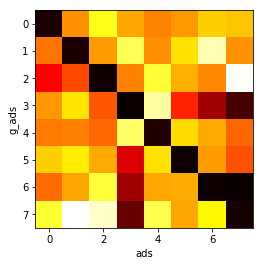

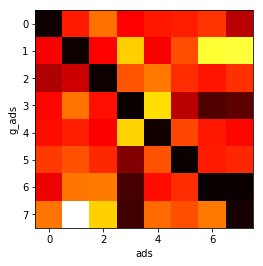

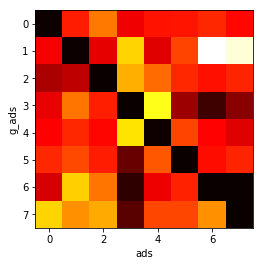

In [48]:
for n in range(2,6,1):
    getMatchness(getMatchScoreExtendedMultiplicative,ads,g_ads,n)

This method seems not better than previous scoring method. It's even worse.

What's wrong with `ads[7]` and `g_ads[6]`? and `ads[6]` and `g_ads[3]`. They both have troubled both scoring methods.

Look at the starting 4 frames of both `ads[7]` and `g_ads[6]`.

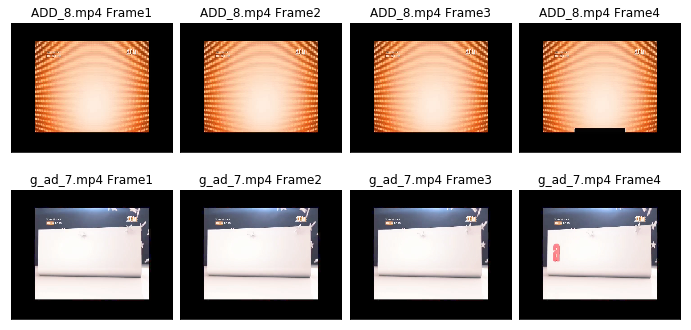

In [49]:
reader1,reader2=skvideo.io.FFmpegReader(ads[7]),skvideo.io.FFmpegReader(g_ads[6])
fig, axes = plt.subplots(2, 4, figsize=(12, 6),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.05, wspace=0.05)

for ax, counter in zip(axes.flat, range(8)):
    if counter<4:
        ax.imshow(reader1._readFrame())
        ax.set_title("%s Frame%i"%(ads[7][-9:],counter+1))
    else:
        ax.imshow(reader2._readFrame())
        ax.set_title("%s Frame%i"%(g_ads[6],counter+1-4))
reader1.close()
reader2.close()
plt.show()

????

Do the same for `ads[6]` and `g_ads[3]`.

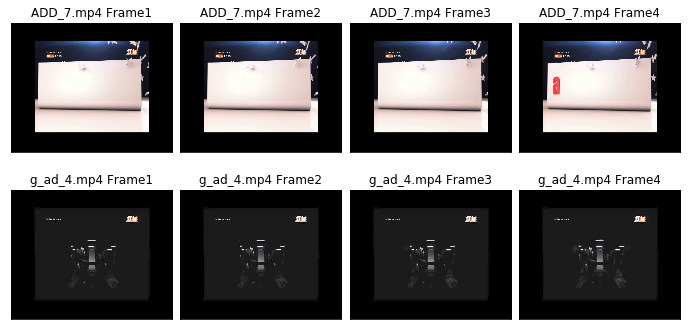

In [50]:
reader1,reader2=skvideo.io.FFmpegReader(ads[6]),skvideo.io.FFmpegReader(g_ads[3])
fig, axes = plt.subplots(2, 4, figsize=(12, 6),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.05, wspace=0.05)

for ax, counter in zip(axes.flat, range(8)):
    if counter<4:
        ax.imshow(reader1._readFrame())
        ax.set_title("%s Frame%i"%(ads[6][-9:],counter+1))
    else:
        ax.imshow(reader2._readFrame())
        ax.set_title("%s Frame%i"%(g_ads[3],counter+1-4))
reader1.close()
reader2.close()
plt.show()

I think what's wrong here is that these videos' frames don't change rapidly so that their `interestPoints` is quite sparse making decisions less accurate.
To verify that fact let's examine `sumInterest` values.

The results show that `ads[7]` and `g_ads[1]` are strongly uncorrelated. Out of suspicion let's have a look at the 1st 4 frames of them also. 

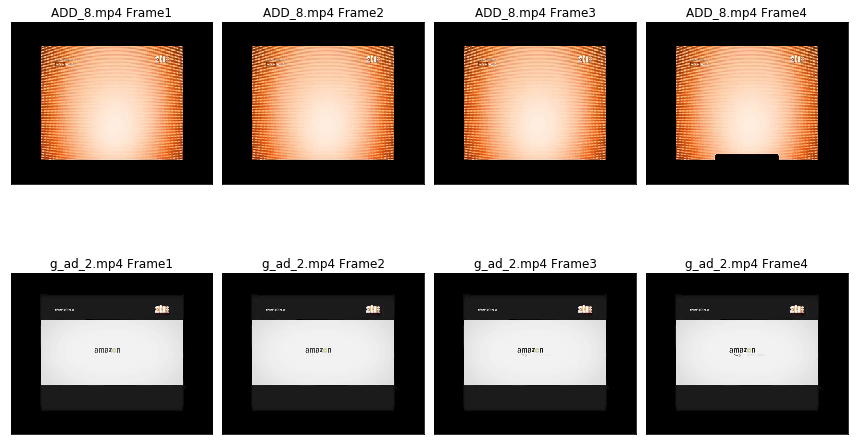

In [51]:
reader1,reader2=skvideo.io.FFmpegReader(ads[7]),skvideo.io.FFmpegReader(g_ads[1])
fig, axes = plt.subplots(2, 4, figsize=(15, 9),
                         subplot_kw={'xticks': [], 'yticks': []})

fig.subplots_adjust(hspace=0.05, wspace=0.05)

for ax, counter in zip(axes.flat, range(8)):
    if counter<4:
        ax.imshow(reader1._readFrame())
        ax.set_title("%s Frame%i"%(ads[7][-9:],counter+1))
    else:
        ax.imshow(reader2._readFrame())
        ax.set_title("%s Frame%i"%(g_ads[1],counter+1-4))
reader1.close()
reader2.close()
plt.show()

Let's see how many interest points are for each of the adjacent frames.

Redefine `getMatchScoreExtended` for our use

In [24]:
def getMatchScoreExtended_debug(vid1,vid2,n):
    """give score using first n frames using same algo
        as getMatchScore.
    """
    reader1 = skvideo.io.FFmpegReader(vid1)
    reader2 = skvideo.io.FFmpegReader(vid2)
    frameCountError(reader1,n+1)
    frameCountError(reader2,n+1)
    lastFrameVid1, lastFrameVid2 = reader1._readFrame(),reader2._readFrame()
    out = 1
    for i in range(n):
        nowFrameVid1,nowFrameVid2 = reader1._readFrame(),reader2._readFrame()
        inc1,dec1,incdec1 = getChange(lastFrameVid1,nowFrameVid1,1)
        inc2,dec2,incdec2 = getChange(lastFrameVid2,nowFrameVid2,1)
        lastFrameVid1,LastFrameVid2 = nowFrameVid1,nowFrameVid2
        interestPoints = np.logical_and(incdec1,incdec2)
        cleanInc1,cleanInc2 = np.logical_and(interestPoints,np.array([inc1,inc2])) 
        incScoreMat = np.logical_xor(cleanInc1,cleanInc2)
        incScore = np.sum(incScoreMat)
        sumInterest = np.sum(interestPoints)
        
        print('%i - %i \t sumInterest = %i \t incScore = %i'%(i+1,i+2,sumInterest,incScore))
        if sumInterest:
            out *= (incScore)/sumInterest
    reader1.close()
    reader2.close()
    return out

In [53]:
getMatchScoreExtended_debug(ads[7],g_ads[1],4)

1 - 2 	 sumInterest = 76 	 incScore = 59
2 - 3 	 sumInterest = 125 	 incScore = 50
3 - 4 	 sumInterest = 67 	 incScore = 24
4 - 5 	 sumInterest = 0 	 incScore = 0


0.11123330714846819

Do the same for `ads[6]` and `g_ads[3]`

In [54]:
getMatchScoreExtended_debug(ads[6],g_ads[1],4)

1 - 2 	 sumInterest = 823 	 incScore = 435
2 - 3 	 sumInterest = 1431 	 incScore = 762
3 - 4 	 sumInterest = 2021 	 incScore = 1262
4 - 5 	 sumInterest = 3109 	 incScore = 1945


0.10995036725719835

Surprisingly number of interst points are not that small.

But since the number of pixels of our video is quite high, ie

In [55]:
getFrame(ads[0],1)[:,:,0].size

414720

But wait..! There's a black padding around video. We should neglect it since it won't ever come as an interest point.

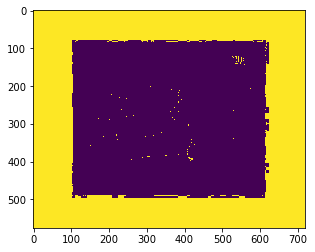

203136

In [26]:
border = getFrame(ads[0],1)[:,:,0]==getFrame(ads[1],1)[:,:,0] # this is just a guess
plt.imshow(border);plt.show()
np.sum(border)

more accurate numbr of pixels will be the obvious count in center removed

In [27]:
203136-np.sum(border[100:450,120:600])

202496

Okay... So effective number of pixels is

In [28]:
414720-202496

212224

Even though `sumInerest` is $3000$ the proportion is:

In [29]:
3000/222222

0.0135000135000135

almost 1% which is not good...

How about skipping frames. Then there would be more interest points hopefully.

Modify `getMatchScoreExtended` to `getMatchscoreSkipped`

In [30]:
def getMatchScoreSkipped(vid1,vid2,n,step):
    """give score using first n frames using same algo
        as getMatchScore.
    """
    reader1 = skvideo.io.FFmpegReader(vid1)
    reader2 = skvideo.io.FFmpegReader(vid2)
    frameCountError(reader1,n+1)
    frameCountError(reader2,n+1)
    lastFrameVid1, lastFrameVid2 = reader1._readFrame(),reader2._readFrame()
    out = 1
    for i in range(0,n,step):
        
        # skipping frames
        for i in range(step):
            nowFrameVid1,nowFrameVid2 = reader1._readFrame(),reader2._readFrame()

        inc1,dec1,incdec1 = getChange(lastFrameVid1,nowFrameVid1,1)
        inc2,dec2,incdec2 = getChange(lastFrameVid2,nowFrameVid2,1)
        lastFrameVid1,LastFrameVid2 = nowFrameVid1,nowFrameVid2
        interestPoints = np.logical_and(incdec1,incdec2)
        cleanInc1,cleanInc2 = np.logical_and(interestPoints,np.array([inc1,inc2])) 
        incScoreMat = np.logical_xor(cleanInc1,cleanInc2)
        incScore = np.sum(incScoreMat)
        sumInterest = np.sum(interestPoints)
        if sumInterest != 0: out += (incScore)/sumInterest
    reader1.close()
    reader2.close()

    return out 

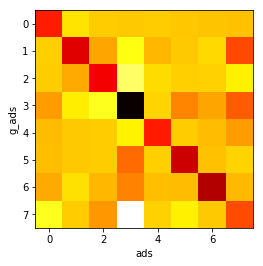

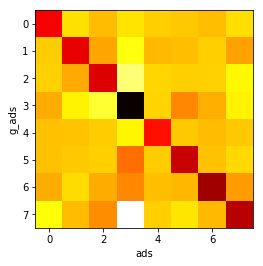

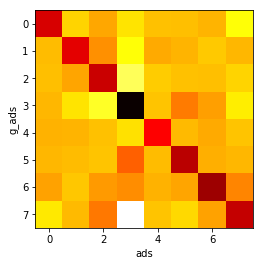

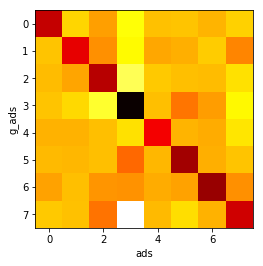

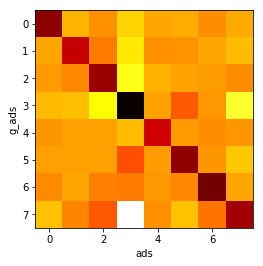

In [61]:
for step in range(1,6,1):
    getMatchScoreSkipped_by = lambda  vid1,vid2,n:getMatchScoreSkipped(vid1,vid2,n,step)
    getMatchness(getMatchScoreSkipped_by,ads,g_ads,25)

This is not satisfactory the reasin being frames not changed a lot during small amount of time. (Here maximum time is about $40\times5 = 200 ~ms$)

![](idea.png)
> Instead of compare with the next frame what about comparing with transformed version of the same frame?

# Algorithm 2

![](Algo2.svg)